In [2]:
from functions import *
import matplotlib.pyplot as plt
import pickle
from parameters_schuelzgen import *

Plot linear spectrum and exciting field:

In [3]:
with open('results/schuelzgen/Qdim=700_Qmax=1.5_power0.00001sigma=90_pf_corr=9.0_n_wells1_z2500320.0_reflectionsFalse_quadratic_grid_polarizations.pickle', 'rb') as input_file:
    pol_linear = pickle.load(input_file)[0]
abs_linear = get_absorption_SQW(pol_linear, t_c, tlist,omega_list,  np.sqrt(0.68*float(0.00001)*9*6.24157*1e-2*4*np.sqrt(np.pi)*sigma/(epsilon_0*c*n_medium)), 90, omega_0, n_medium, pulse_shape = 'gauss', method = 'lambert_beer')
E_w = fouriertrafo(gauss_pulse(tlist,0.00001, 456.4321, t_c), omega_list, tlist)

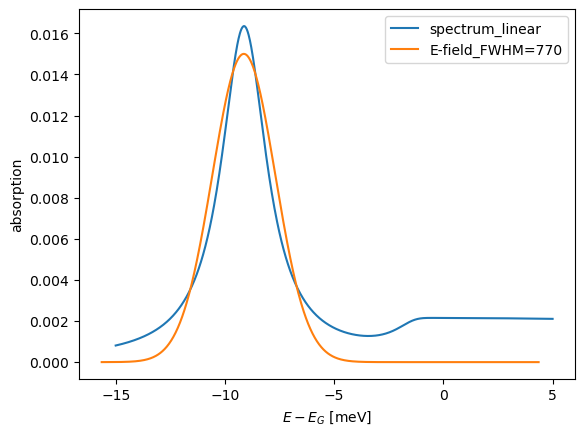

In [4]:
plt.plot(1000* hbar*(omega_list - 0.012903883497007542), abs_linear, label = 'spectrum_linear')
plt.plot(1000* hbar*(omega_list -0.012903883497007542-0.0009733041176293242), 1500*np.abs(E_w), label = 'E-field_FWHM=770')
plt.ylabel('absorption')
plt.xlabel(r'$E-E_G$ [meV]')
plt.legend()

Reproduce fig. 2b

/usr/local/python3/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/python3/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


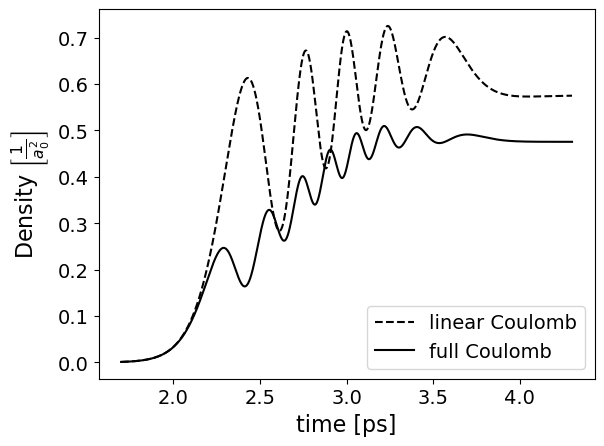

In [5]:
from parameters_schuelzgen import tlist
from parameters_general import bohr_radius
#crop data to pulse region
start = 17000
end = 43000
tlist_cropped = tlist[start:end]

with open('results/schuelzgen/Qdim=700_Qmax=1.5_power16_pf_corr=9.0_n_wells1_z2500320.0_reflectionsFalse_quadratic_grid_occupations.pickle', 'rb') as input_file:
    nonlinear_coulomb = pickle.load(input_file)[0][start:end]
with open('results/schuelzgen/Qdim=700_Qmax=1.5_power16_no_nonl_coulomb_pf_corr=9.0_n_wells1_z2500320.0_reflectionsFalse_quadratic_grid_occupations.pickle', 'rb') as input_file:
    linear_coulomb = pickle.load(input_file)[0][start:end]

plt.plot(tlist_cropped/1000, linear_coulomb*bohr_radius**2, 'k--',label = 'linear Coulomb')
plt.plot(tlist_cropped/1000, nonlinear_coulomb*bohr_radius**2, 'k-',label = 'full Coulomb')
plt.xlabel('time [ps]', fontsize = 16)
plt.ylabel(r'Density $\left[\frac{1}{a_0^2}\right]$', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(fontsize = 14)
plt.savefig('results/schuelzgen/figure2b.pdf', bbox_inches = 'tight')

Next, we want to determine the Rabi frequencies at different field strengths, by measuring the time differences between the occupation maxima/minima and taking the smallest difference between two maxima/minima

In [6]:
#read N(t) arrays for different fluences and crop to approximate pulse duration:
occupations = []
fluences = [0.5, 1.5, 1, 2, 4, 6, 9, 10, 12, 14, 16,20, 25]
for fluence in fluences:
    with open('results/schuelzgen/Qdim=700_Qmax=1.5_power{}_pf_corr=9.0_n_wells1_z2500320.0_reflectionsFalse_quadratic_grid_occupations.pickle'.format(fluence), 'rb') as input_file:
        occupations.append(pickle.load(input_file)[0][start:end])
    

/usr/local/python3/lib/python3.10/site-packages/scipy/signal/_peak_finding.py:265: ComplexWarning: Casting complex values to real discards the imaginary part
  value = np.asarray(value, order='C', dtype=np.float64)


Text(0, 0.5, 'Rabi frequency [THz]')

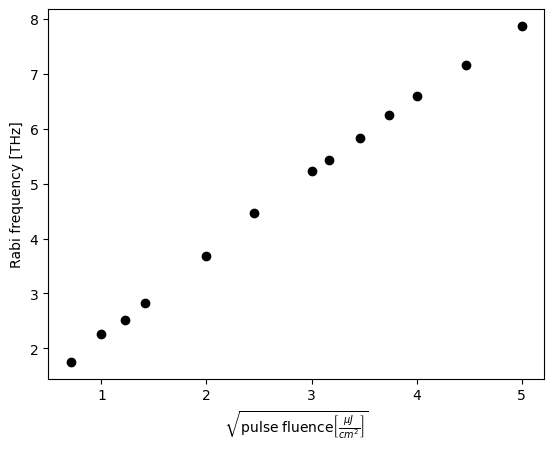

In [ ]:
from scipy.signal import find_peaks
# find rabi frequencies from single shortest oscillation
rabi_frequencies = np.zeros_like(fluences)
for i in range(len(fluences)):
    maxima, _ = find_peaks(occupations[i], height=0)
    minima, _ = find_peaks(-occupations[i])
    tmax_list = tlist_cropped[maxima]
    tmin_list = tlist_cropped[minima]
    diffs_maxima = np.diff(tmax_list)
    diffs_minima = np.diff(tmin_list)
    rabi_frequencies[i] = 1/np.min(np.concatenate((diffs_maxima, diffs_minima)))*1e3

plt.scatter(np.sqrt(fluences), rabi_frequencies, c = 'black')
plt.xlabel(r"$\sqrt{\mathrm{pulse\;fluence} \left[\frac{n J}{cm^2}\right]}$")
plt.ylabel('Rabi frequency [THz]')

Add linear fit and rabi frequencies for restriction to linear coulomb interaction

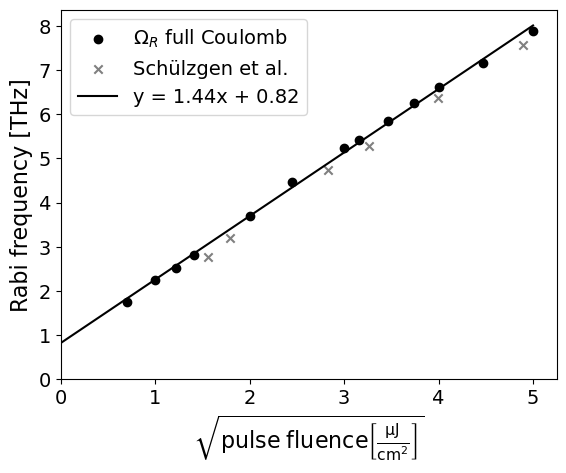

In [ ]:
extended_fluences = np.sqrt(np.linspace(0,fluences[-1], 20)) #create equidistant x-values, including zero

coefficients = np.polyfit(np.sqrt(fluences), rabi_frequencies, 1)  # degree 1 for linear
y_with_intercept = np.polyval(coefficients, extended_fluences)
# Fit a linear equation without intercept (y = mx, forcing the offset to be 0)
slope_without_intercept, _, _, _ = np.linalg.lstsq(np.sqrt(fluences).reshape(-1, 1), rabi_frequencies, rcond=None)
y_without_intercept = slope_without_intercept * extended_fluences

x_schuelzgen = [1.5558019216555803,1.7886178861788617,2.827050997782705,3.2668144863266813,3.9948263118994825,4.896526237989653]
y_schuelzgen = [2.772093023255814,3.2,4.7441860465116275,5.274418604651163,6.362790697674418,7.572093023255814]
# Plot the data points
plt.scatter(np.sqrt(fluences), rabi_frequencies, color='black', label=r'$\Omega_R$ full Coulomb')
plt.scatter(x_schuelzgen, y_schuelzgen,color = 'grey', marker = 'x', label = 'Schülzgen et al.')

# Plot the fitted lines
plt.plot(extended_fluences, y_with_intercept, color='black', linestyle = '-' , label=f'y = {coefficients[0]:.2f}x + {coefficients[1]:.2f}')
#plt.plot(extended_fluences, y_without_intercept, color='black', linestyle='--', label=f'y = {slope_without_intercept[0]:.2f}x')
#plt.plot(extended_fluences, np.sqrt(0.68*extended_fluences**2*9*6.24157*1e-2*4*np.sqrt(np.pi)*sigma/(epsilon_0*c*n_medium))*d_cv/(hbar)/(np.sqrt(2*np.pi)*sigma)*1e3, color = 'black', linestyle = 'dotted',label = r'$\Omega_R=\frac{d^{cv}E_{max}}{\hbar}$')
plt.xlim(left=0)
plt.ylim(bottom=0)

plt.xlabel(r"$\sqrt{\mathrm{pulse\;fluence} \left[\frac{\mathrm{n J}}{\mathrm{cm}^2}\right]}$", fontsize = 16)
plt.ylabel('Rabi frequency [THz]', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(fontsize = 14)
plt.savefig('results/schuelzgen/figure3.pdf', bbox_inches = 'tight')


 
 
 
 
 
 

Evaluating the Rabi frequencies based on the two shortest oscillations as in the paper, we get:

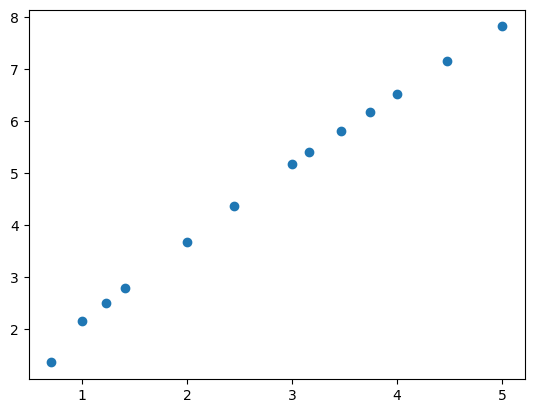

In [9]:
from scipy.signal import find_peaks
# find rabi frequencies from two smallest oscillations
rabi_frequencies = np.zeros_like(fluences)
for i in range(len(fluences)):
    maxima, _ = find_peaks(occupations[i], height=0)
    minima, _ = find_peaks(-occupations[i])
    tmax_list = tlist_cropped[maxima]
    tmin_list = tlist_cropped[minima]
    diffs_maxima = np.diff(tmax_list)
    diffs_minima = np.diff(tmin_list)
    smallest_two = sorted(np.concatenate((diffs_maxima, diffs_minima)))[:2]
    rabi_frequencies[i] = 1/np.mean(smallest_two)*1e3

plt.scatter(np.sqrt(fluences), rabi_frequencies)

/usr/lib/python3/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/lib/python3/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/lib/python3/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/lib/python3/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


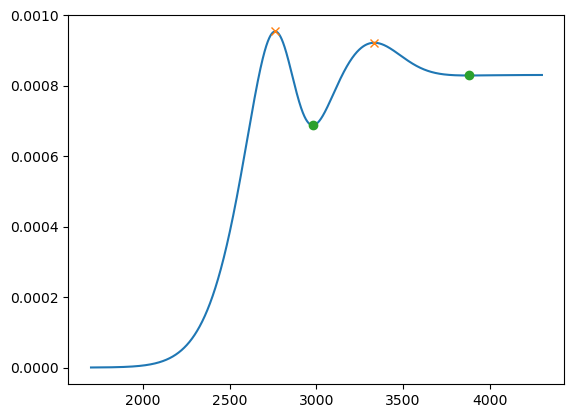

Times of maxima:  [2762.  3333.3]
Times of minima:  [2979.2 3878.4]
[571.3]
[899.2]
1.7503938386136875


In [36]:
from scipy.signal import find_peaks
# look for local maxima and return corresponding time values
i = 0
maxima, _ = find_peaks(occupations[i], height=0)
minima, _ = find_peaks(-occupations[i])
tmax_list = tlist_cropped[maxima]
tmin_list = tlist_cropped[minima]
plt.plot(tlist_cropped,occupations[i])
plt.plot(tmax_list, occupations[i][maxima], "x")
plt.plot(tmin_list, occupations[i][minima], "o")
plt.show()
print('Times of maxima: ', tmax_list)
print('Times of minima: ', tmin_list)
diffs_maxima = np.diff(tmax_list)
diffs_minima = np.diff(tmin_list)
print(diffs_maxima)
print(diffs_minima)
rabi_frequency = 1/np.min(np.concatenate((diffs_maxima, diffs_minima)))*1e3
print(rabi_frequency)

In [11]:

np.sqrt(0.68*float(16)*1*6.24157*1e-2*4*np.sqrt(np.pi)*sigma/(epsilon_0*c*n_medium))*d_cv/(hbar)/(np.sqrt(2*np.pi)*sigma)*1e3

9.209109578808079

In [5]:
np.sqrt(0.68*float(16)*1*6.24157*1e-2*4*np.sqrt(np.pi)*sigma*3.6/(epsilon_0*c))*d_cv*2/(hbar*np.pi)

12.232302202082712

In [6]:
np.sqrt(0.68*float(16)*9*6.24157*1e-2*4*np.sqrt(np.pi)*sigma/(epsilon_0*c*n_medium))*d_cv*2/(hbar*np.pi)

10.19358516840226